# Build movie recommendation system

```
1. Import our dependencies
2. Load dataset
3. Understand dataset
4. Pre-processing steps (We will perform the pre-processing steps as and when needed)
5. Build recommendation system
    5.1 Content based recommendation system
        5.1.1 Implement model
        5.1.2 Evaluate Result
```   

## 1. Import libraries

In [657]:

import pandas as pd
import numpy as np
import ast 
from ast import literal_eval
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from surprise import Reader, Dataset, SVD
from surprise import Dataset
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.model_selection import cross_validate
import matplotlib.pyplot as plt


## 2. Load dataset

We have MovieLens datasets.

**The Full Dataset:** Consists of 26,000,000 ratings and 750,000 tag applications applied to 45,000 movies by 270,000 users. Includes tag genome data with 12 million relevance scores across 1,100 tags.

**The Small Dataset:** Comprises of 100,000 ratings and 1,300 tag applications applied to 9,000 movies by 700 users.

We will build our Simple Recommender using movies from the Full Dataset 

In [658]:
credits = pd.read_csv('credits.csv')
keywords = pd.read_csv('keywords.csv')
links_small = pd.read_csv('links_small.csv')
md = pd.read_csv('movies_metadata.csv')
ratings = pd.read_csv('ratings_small.csv')

C:\Users\Uddesh\AppData\Local\Temp\ipykernel_22320\2252783192.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  md = pd.read_csv('movies_metadata.csv')


## 3. Understand dataset

#### Credits dataframe

In [659]:
credits.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [660]:
credits.columns

Index(['cast', 'crew', 'id'], dtype='object')

* **cast:** Information about casting. Name of actor, gender and it's character name in movie
* **crew:** Information about crew members. Like who directed the movie, editor of the movie and so on. 
* **id:** It's movie ID given by TMDb

In [661]:
credits.shape

(45476, 3)

In [662]:
credits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45476 entries, 0 to 45475
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   cast    45476 non-null  object
 1   crew    45476 non-null  object
 2   id      45476 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


#### Keywords dataframe

In [663]:
keywords.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [664]:
keywords.columns

Index(['id', 'keywords'], dtype='object')

* **id:** It's movie ID given by TMDb
* **Keywords:** Tags/keywords for the movie. It list of tags/keywords 

In [665]:
keywords.shape

(46419, 2)

In [666]:
keywords.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46419 entries, 0 to 46418
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        46419 non-null  int64 
 1   keywords  46419 non-null  object
dtypes: int64(1), object(1)
memory usage: 725.4+ KB


#### Link dataframe

In [667]:
links_small.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [668]:
links_small.columns

Index(['movieId', 'imdbId', 'tmdbId'], dtype='object')

* **movieId:** It's serial number for movie
* **imdbId:** Movie id given on IMDb platform
* **tmdbId**: Movie id given on TMDb platform

In [669]:
links_small.shape

(9125, 3)

In [670]:
links_small.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9125 entries, 0 to 9124
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9125 non-null   int64  
 1   imdbId   9125 non-null   int64  
 2   tmdbId   9112 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 214.0 KB


#### Metadata dataframe

In [671]:
md.iloc[0:3].transpose()

,0,1,2
adult,False,False,False
belongs_to_collection,"{'id': 10194, 'name': 'Toy Story Collection', ...",NaN,"{'id': 119050, 'name': 'Grumpy Old Men Collect..."
budget,30000000,65000000,0
genres,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...","[{'id': 10749, 'name': 'Romance'}, {'id': 35, ..."
homepage,http://toystory.disney.com/toy-story,NaN,NaN
id,862,8844,15602
imdb_id,tt0114709,tt0113497,tt0113228
original_language,en,en,en
original_title,Toy Story,Jumanji,Grumpier Old Men
overview,"Led by Woody, Andy's toys live happily in his ...",When siblings Judy and Peter discover an encha...,A family wedding reignites the ancient feud be...


In [672]:
md.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

**Features**

* **adult:** Indicates if the movie is X-Rated or Adult.
* **belongs_to_collection:** A stringified dictionary that gives information on the movie series the particular film belongs to.
* **budget:** The budget of the movie in dollars.
* **genres:** A stringified list of dictionaries that list out all the genres associated with the movie.
* **homepage:** The Official Homepage of the move.
* **id:** The ID of the movie.
* **imdb_id:** The IMDB ID of the movie.
* **original_language:** The language in which the movie was originally shot in.
* **original_title:** The original title of the movie.
* **overview:** A brief blurb of the movie.
* **popularity:** The Popularity Score assigned by TMDB.
* **poster_path:** The URL of the poster image.
* **production_companies:** A stringified list of production companies involved with the making of the movie.
* **production_countries:** A stringified list of countries where the movie was shot/produced in.
* **release_date:** Theatrical Release Date of the movie.
* **revenue:** The total revenue of the movie in dollars.
* **runtime:** The runtime of the movie in minutes.
* **spoken_languages:** A stringified list of spoken languages in the film.
* **status:** The status of the movie (Released, To Be Released, Announced, etc.)
* **tagline:** The tagline of the movie.
* **title:** The Official Title of the movie.
* **video:** Indicates if there is a video present of the movie with TMDB.
* **vote_average:** The average rating of the movie.
* **vote_count:** The number of votes by users, as counted by TMDB.

In [673]:
md.shape

(45466, 24)

In [674]:
md.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

#### Ratings dataframe

In [675]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [676]:
ratings.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

* **userId:** It is id for User
* **movieId:** It is TMDb movie id.
* **rating:** Rating given for the particular movie by specific user
* **timestamp:** Time stamp when rating has been given by user

In [677]:
ratings.shape

(100004, 4)

In [678]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


## 4. Pre-processing 

* We will perform pre-processing as and when needed throughout the project

## 5. Build recommendation system

### 5.1 Content based recommendation system

#### 'links_small' DataFrame, filters it to include only rows with valid 'tmdbId' values (i.e., not null), and then converts the 'tmdbId' column to contain integers. 

In [679]:
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')
links_small

0          862
1         8844
2        15602
3        31357
4        11862
         ...  
9120    402672
9121    315011
9122    391698
9123    137608
9124    410803
Name: tmdbId, Length: 9112, dtype: int32

In [680]:
## Pre-processing step

def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan


In [681]:
md['id'] = md['id'].apply(convert_int)
md[md['id'].isnull()]

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
19730,- Written by Ørnås,0.065736,/ff9qCepilowshEtG2GYWwzt2bs4.jpg,"[{'name': 'Carousel Productions', 'id': 11176}...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",NaN,0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29503,Rune Balot goes to a casino connected to the ...,1.931659,/zV8bHuSL6WXoD6FWogP9j4x80bL.jpg,"[{'name': 'Aniplex', 'id': 2883}, {'name': 'Go...","[{'iso_3166_1': 'US', 'name': 'United States o...",NaN,0,68.0,"[{'iso_639_1': 'ja', 'name': '日本語'}]",Released,...,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35587,Avalanche Sharks tells the story of a bikini ...,2.185485,/zaSf5OG7V8X8gqFvly88zDdRm46.jpg,"[{'name': 'Odyssey Media', 'id': 17161}, {'nam...","[{'iso_3166_1': 'CA', 'name': 'Canada'}]",NaN,0,82.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,...,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [682]:
md['id']

0           862.0
1          8844.0
2         15602.0
3         31357.0
4         11862.0
           ...   
45461    439050.0
45462    111109.0
45463     67758.0
45464    227506.0
45465    461257.0
Name: id, Length: 45466, dtype: float64

In [683]:
md = md.drop([19730, 29503, 35587])

__9000+ movies__ available in our small movies metadata dataset which is 5 times smaller than our original dataset of 45000 movies.

### Content based RS : Using movie overview, keywords, cast, director and genres

* To build our standard metadata based content recommender, we will need to __merge our current dataset with the 
  crew and the keyword datasets__. 
* Let us prepare this data as our first step.

In [684]:
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
ratings['id']=ratings['movieId']
ratings['id']=ratings['id'].astype('int')

In [685]:
md.shape

(45463, 24)

In [686]:
md = md.merge(credits, on='id')
md = md.merge(keywords, on='id')

#### isin() method is used to filter data frames. isin() method helps in selecting rows with having a particular(or Multiple) value in a particular column.

In [687]:
smd = md[md['id'].isin(links_small)]
smd.shape

(9219, 27)

We have __9219 movies__ available in our small movies metadata dataset which is 5 times smaller than our original dataset of 45000 movies.

We now have our cast, crew, genres and credits, all in one dataframe. Let us wrangle this a little more using the following intuitions:

**1. Crew:** From the crew, we will only pick the director as our feature since the others don't contribute that much to the feel of the movie.

**2. Cast:** Choosing Cast is a little more tricky. Lesser known actors and minor roles do not really affect people's opinion of a movie. Therefore, we must only select the major characters and their respective actors. Arbitrarily we will choose the top 3 actors that appear in the credits list.

In [688]:
movies=smd
movies

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,spoken_languages,status,tagline,title,video,vote_average,vote_count,cast,crew,keywords
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862.0,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844.0,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602.0,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357.0,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862.0,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40952,False,NaN,8000000,"[{'id': 18, 'name': 'Drama'}]",NaN,159550.0,tt0255313,en,The Last Brickmaker in America,A man must cope with the loss of his wife and ...,...,[],Released,NaN,The Last Brickmaker in America,False,7.0,1.0,"[{'cast_id': 1, 'character': 'Henry Cobb', 'cr...","[{'credit_id': '544475aac3a36819fb000578', 'de...","[{'id': 6054, 'name': 'friendship'}, {'id': 20..."
41172,False,NaN,1000000,"[{'id': 53, 'name': 'Thriller'}, {'id': 10749,...",NaN,392572.0,tt5165344,hi,रुस्तम,"Rustom Pavri, an honourable officer of the Ind...",...,"[{'iso_639_1': 'hi', 'name': 'हिन्दी'}]",Released,Decorated Officer. Devoted Family Man. Defendi...,Rustom,False,7.3,25.0,"[{'cast_id': 0, 'character': 'Rustom Pavri', '...","[{'credit_id': '5951baf692514129c4016600', 'de...","[{'id': 10540, 'name': 'bollywood'}]"
41225,False,NaN,15050000,"[{'id': 12, 'name': 'Adventure'}, {'id': 18, '...",NaN,402672.0,tt3859980,hi,Mohenjo Daro,"Village lad Sarman is drawn to big, bad Mohenj...",...,"[{'iso_639_1': 'hi', 'name': 'हिन्दी'}]",Released,NaN,Mohenjo Daro,False,6.7,26.0,"[{'cast_id': 0, 'character': 'Sarman', 'credit...","[{'credit_id': '57cd5d3592514179d50018e8', 'de...","[{'id': 10540, 'name': 'bollywood'}]"
41391,False,NaN,15000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",NaN,315011.0,tt4262980,ja,シン・ゴジラ,

In [689]:
movies = movies[['id','original_title','overview','genres','keywords','cast','crew','vote_average','vote_count']]

In [690]:
movies

,id,original_title,overview,genres,keywords,cast,crew,vote_average,vote_count
0,862.0,Toy Story,"Led by Woody, Andy's toys live happily in his ...","[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",7.7,5415.0
1,8844.0,Jumanji,When siblings Judy and Peter discover an encha...,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...","[{'id': 10090, 'name': 'board game'}, {'id': 1...","[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",6.9,2413.0
2,15602.0,Grumpier Old Men,A family wedding reignites the ancient feud be...,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392...","[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",6.5,92.0
3,31357.0,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...","[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","[{'id': 818, 'name': 'based on novel'}, {'id':...","[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",6.1,34.0
4,11862.0,Father of the Bride Part II,Just when George Banks has recovered from his ...,"[{'id': 35, 'name': 'Comedy'}]","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...","[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",5.7,173.0
...,...,...,...,...,...,...,...,...,...
40952,159550.0,The Last Brickmaker in America,A man must cope with the loss of his wife and ...,"[{'id': 18, 'name': 'Drama'}]","[{'id': 6054, 'name': 'friendship'}, {'id': 20...","[{'cast_id': 1, 'character': 'Henry Cobb', 'cr...","[{'credit_id': '544475aac3a36819fb000578', 'de...",7.0,1.0
41172,392572.0,रुस्तम,"Rustom Pavri, an honourable officer of the Ind...","[{'id': 53, 'name': 'Thriller'}, {'id': 10749,...","[{'id': 10540, 'name': 'bollywood'}]","[{'cast_id': 0, 'character': 'Rustom Pavri', '...","[{'credit_id': '5951baf692514129c4016600', 'de...",7.3,25.0
41225,402672.0,Mohenjo Daro,"Village lad Sarman is drawn to big, bad Mohenj...","[{'id': 12, 'name': 'Adventure'}, {'id': 18, '...","[{'id': 10540, 'name': 'bollywood'}]","[{'cast_id': 0, 'character': 'Sarman', 'credit...","[{'credit_id': '57cd5d3592514179d50018e8', 'de...",6.7,26.0
41391,315011.0,シン・ゴジラ,From the mind behind Evangelion comes a hit la...,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...","[{'id': 1299, 'name': 'monster'}, {'id': 7671,...","[{'cast_id': 4, 'character': 'Rando Yaguchi : ...","[{'credit_id': '560892fa92514177550018b2', 'de...",6.6,152.0


In [691]:
movies.isnull().sum()

id                 0
original_title     0
overview          12
genres             0
keywords           0
cast               0
crew               0
vote_average       0
vote_count         0
dtype: int64

In [692]:
movies.dropna(inplace=True)

C:\Users\Uddesh\AppData\Local\Temp\ipykernel_22320\3786870272.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies.dropna(inplace=True)


In [693]:
movies.isnull().sum()

id                0
original_title    0
overview          0
genres            0
keywords          0
cast              0
crew              0
vote_average      0
vote_count        0
dtype: int64

In [694]:
movies.iloc[0].genres

"[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]"

In [695]:
ast.literal_eval("[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]")

[{'id': 16, 'name': 'Animation'},
 {'id': 35, 'name': 'Comedy'},
 {'id': 10751, 'name': 'Family'}]

In [696]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Assuming you have a DataFrame 'movies' with columns 'overview', 'genres', and 'rating'
# Replace it with your actual DataFrame or data structure
# Extract content features
content_features = movies['overview'] +' '+ movies['genres']+' '+movies['keywords']+movies['crew']+movies['cast']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(content_features, movies['vote_average'], test_size=0.2, random_state=42)

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Build a linear regression model
model = LinearRegression()
model.fit(X_train_tfidf, y_train)

# Make predictions on the test set
predictions = model.predict(X_test_tfidf)

# Calculate the RMSE
rmse = mean_squared_error(y_test, predictions, squared=False)
print(f'RMSE: {rmse}')

RMSE: 0.8458514722271445


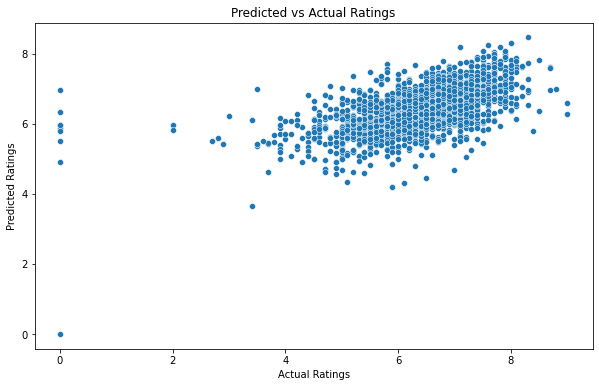

In [697]:
# Visualize predicted vs actual ratings
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=predictions)
plt.title('Predicted vs Actual Ratings')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.show()

In [698]:
def convert(obj):
    L=[]
    for i in ast.literal_eval(obj):
        L.append(i['name'])
    return L  

In [699]:
movies['genres'].apply(convert)

0                              [Animation, Comedy, Family]
1                             [Adventure, Fantasy, Family]
2                                        [Romance, Comedy]
3                                 [Comedy, Drama, Romance]
4                                                 [Comedy]
                               ...                        
40952                                              [Drama]
41172                                  [Thriller, Romance]
41225                 [Adventure, Drama, History, Romance]
41391    [Action, Adventure, Drama, Horror, Science Fic...
41669                                 [Documentary, Music]
Name: genres, Length: 9207, dtype: object

In [700]:
movies['genres']=movies['genres'].apply(convert)

C:\Users\Uddesh\AppData\Local\Temp\ipykernel_22320\1567952790.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['genres']=movies['genres'].apply(convert)


In [701]:
movies['keywords']=movies['keywords'].apply(convert)

C:\Users\Uddesh\AppData\Local\Temp\ipykernel_22320\1621871954.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['keywords']=movies['keywords'].apply(convert)


In [702]:
def fetch_cast(obj):
    L=[]
    count=0;
    for i in ast.literal_eval(obj):
        if count<3:
            L.append(i['name'])
            count=count+1
        else:
            break   
    return L  

In [703]:
movies['cast'].apply(fetch_cast)

0                      [Tom Hanks, Tim Allen, Don Rickles]
1           [Robin Williams, Jonathan Hyde, Kirsten Dunst]
2               [Walter Matthau, Jack Lemmon, Ann-Margret]
3        [Whitney Houston, Angela Bassett, Loretta Devine]
4               [Steve Martin, Diane Keaton, Martin Short]
                               ...                        
40952      [Sidney Poitier, Wendy Crewson, Jay O. Sanders]
41172            [Akshay Kumar, Ileana D'Cruz, Esha Gupta]
41225            [Hrithik Roshan, Pooja Hegde, Kabir Bedi]
41391    [Hiroki Hasegawa, Yutaka Takenouchi, Satomi Is...
41669           [Paul McCartney, Ringo Starr, John Lennon]
Name: cast, Length: 9207, dtype: object

In [704]:
movies['cast']=movies['cast'].apply(fetch_cast)

C:\Users\Uddesh\AppData\Local\Temp\ipykernel_22320\2816776861.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['cast']=movies['cast'].apply(fetch_cast)


In [705]:
def get_director(obj):
    L=[]
    for i in ast.literal_eval(obj):
        if i.get('job') == 'Director':
            L.append(i.get('name'))
    return L

In [706]:
movies

,id,original_title,overview,genres,keywords,cast,crew,vote_average,vote_count
0,862.0,Toy Story,"Led by Woody, Andy's toys live happily in his ...","[Animation, Comedy, Family]","[jealousy, toy, boy, friendship, friends, riva...","[Tom Hanks, Tim Allen, Don Rickles]","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",7.7,5415.0
1,8844.0,Jumanji,When siblings Judy and Peter discover an encha...,"[Adventure, Fantasy, Family]","[board game, disappearance, based on children'...","[Robin Williams, Jonathan Hyde, Kirsten Dunst]","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",6.9,2413.0
2,15602.0,Grumpier Old Men,A family wedding reignites the ancient feud be...,"[Romance, Comedy]","[fishing, best friend, duringcreditsstinger, o...","[Walter Matthau, Jack Lemmon, Ann-Margret]","[{'credit_id': '52fe466a9251416c75077a89', 'de...",6.5,92.0
3,31357.0,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...","[Comedy, Drama, Romance]","[based on novel, interracial relationship, sin...","[Whitney Houston, Angela Bassett, Loretta Devine]","[{'credit_id': '52fe44779251416c91011acb', 'de...",6.1,34.0
4,11862.0,Father of the Bride Part II,Just when George Banks has recovered from his ...,[Comedy],"[baby, midlife crisis, confidence, aging, daug...","[Steve Martin, Diane Keaton, Martin Short]","[{'credit_id': '52fe44959251416c75039ed7', 'de...",5.7,173.0
...,...,...,...,...,...,...,...,...,...
40952,159550.0,The Last Brickmaker in America,A man must cope with the loss of his wife and ...,[Drama],"[friendship, brick making]","[Sidney Poitier, Wendy Crewson, Jay O. Sanders]","[{'credit_id': '544475aac3a36819fb000578', 'de...",7.0,1.0
41172,392572.0,रुस्तम,"Rustom Pavri, an honourable officer of the Ind...","[Thriller, Romance]",[bollywood],"[Akshay Kumar, Ileana D'Cruz, Esha Gupta]","[{'credit_id': '5951baf692514129c4016600', 'de...",7.3,25.0
41225,402672.0,Mohenjo Daro,"Village lad Sarman is drawn to big, bad Mohenj...","[Adventure, Drama, History, Romance]",[bollywood],"[Hrithik Roshan, Pooja Hegde, Kabir Bedi]","[{'credit_id': '57cd5d3592514179d50018e8', 'de...",6.7,26.0
41391,315011.0,シン・ゴジラ,From the mind behind Evangelion comes a hit la...,"[Action, Adventure, Drama, Horror, Science Fic...","[monster, godzilla, giant monster, destruction...","[Hiroki Hasegawa, Yutaka Takenouchi, Satomi Is...","[{'credit_id': '560892fa92514177550018b2', 'de...",6.6,152.0


In [707]:
movies['crew'][:1]

0    [{'credit_id': '52fe4284c3a36847f8024f49', 'de...
Name: crew, dtype: object

In [708]:
movies['crew'] = movies['crew'].apply(get_director)

C:\Users\Uddesh\AppData\Local\Temp\ipykernel_22320\338316728.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['crew'] = movies['crew'].apply(get_director)


In [709]:
movies.head()

,id,original_title,overview,genres,keywords,cast,crew,vote_average,vote_count
0,862.0,Toy Story,"Led by Woody, Andy's toys live happily in his ...","[Animation, Comedy, Family]","[jealousy, toy, boy, friendship, friends, riva...","[Tom Hanks, Tim Allen, Don Rickles]",[John Lasseter],7.7,5415.0
1,8844.0,Jumanji,When siblings Judy and Peter discover an encha...,"[Adventure, Fantasy, Family]","[board game, disappearance, based on children'...","[Robin Williams, Jonathan Hyde, Kirsten Dunst]",[Joe Johnston],6.9,2413.0
2,15602.0,Grumpier Old Men,A family wedding reignites the ancient feud be...,"[Romance, Comedy]","[fishing, best friend, duringcreditsstinger, o...","[Walter Matthau, Jack Lemmon, Ann-Margret]",[Howard Deutch],6.5,92.0
3,31357.0,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...","[Comedy, Drama, Romance]","[based on novel, interracial relationship, sin...","[Whitney Houston, Angela Bassett, Loretta Devine]",[Forest Whitaker],6.1,34.0
4,11862.0,Father of the Bride Part II,Just when George Banks has recovered from his ...,[Comedy],"[baby, midlife crisis, confidence, aging, daug...","[Steve Martin, Diane Keaton, Martin Short]",[Charles Shyer],5.7,173.0


In [710]:
movies['overview']

0        Led by Woody, Andy's toys live happily in his ...
1        When siblings Judy and Peter discover an encha...
2        A family wedding reignites the ancient feud be...
3        Cheated on, mistreated and stepped on, the wom...
4        Just when George Banks has recovered from his ...
                               ...                        
40952    A man must cope with the loss of his wife and ...
41172    Rustom Pavri, an honourable officer of the Ind...
41225    Village lad Sarman is drawn to big, bad Mohenj...
41391    From the mind behind Evangelion comes a hit la...
41669    The band stormed Europe in 1963, and, in 1964,...
Name: overview, Length: 9207, dtype: object

In [711]:
def convert_overview(obj):
    result=obj.split()
    return result

In [712]:
movies['overview']=movies['overview'].apply(convert_overview)

C:\Users\Uddesh\AppData\Local\Temp\ipykernel_22320\4241966416.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['overview']=movies['overview'].apply(convert_overview)


In [713]:
movies['overview']

0        [Led, by, Woody,, Andy's, toys, live, happily,...
1        [When, siblings, Judy, and, Peter, discover, a...
2        [A, family, wedding, reignites, the, ancient, ...
3        [Cheated, on,, mistreated, and, stepped, on,, ...
4        [Just, when, George, Banks, has, recovered, fr...
                               ...                        
40952    [A, man, must, cope, with, the, loss, of, his,...
41172    [Rustom, Pavri,, an, honourable, officer, of, ...
41225    [Village, lad, Sarman, is, drawn, to, big,, ba...
41391    [From, the, mind, behind, Evangelion, comes, a...
41669    [The, band, stormed, Europe, in, 1963,, and,, ...
Name: overview, Length: 9207, dtype: object

* These are steps to follow in the preparation of my genres and credits data:

* Strip Spaces and Convert to Lowercase from all our features. This way, our engine will not confuse between Johnny Depp and Johnny Galecki.

In [714]:
def remove_space(obj):
    L=[]
    for i in obj:
        i=i.replace(" ","")
        L.append(i)
    return L 

In [715]:
movies['keywords'].apply(remove_space)

0        [jealousy, toy, boy, friendship, friends, riva...
1        [boardgame, disappearance, basedonchildren'sbo...
2        [fishing, bestfriend, duringcreditsstinger, ol...
3        [basedonnovel, interracialrelationship, single...
4        [baby, midlifecrisis, confidence, aging, daugh...
                               ...                        
40952                            [friendship, brickmaking]
41172                                          [bollywood]
41225                                          [bollywood]
41391    [monster, godzilla, giantmonster, destruction,...
41669                                 [music, documentary]
Name: keywords, Length: 9207, dtype: object

In [716]:
movies['keywords']=movies['keywords'].apply(remove_space)
movies['genres']=movies['genres'].apply(remove_space)
movies['cast']=movies['cast'].apply(remove_space)
movies['crew']=movies['crew'].apply(remove_space)

C:\Users\Uddesh\AppData\Local\Temp\ipykernel_22320\2681191996.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['keywords']=movies['keywords'].apply(remove_space)
C:\Users\Uddesh\AppData\Local\Temp\ipykernel_22320\2681191996.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['genres']=movies['genres'].apply(remove_space)
C:\Users\Uddesh\AppData\Local\Temp\ipykernel_22320\2681191996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

In [717]:
movies

,id,original_title,overview,genres,keywords,cast,crew,vote_average,vote_count
0,862.0,Toy Story,"[Led, by, Woody,, Andy's, toys, live, happily,...","[Animation, Comedy, Family]","[jealousy, toy, boy, friendship, friends, riva...","[TomHanks, TimAllen, DonRickles]",[JohnLasseter],7.7,5415.0
1,8844.0,Jumanji,"[When, siblings, Judy, and, Peter, discover, a...","[Adventure, Fantasy, Family]","[boardgame, disappearance, basedonchildren'sbo...","[RobinWilliams, JonathanHyde, KirstenDunst]",[JoeJohnston],6.9,2413.0
2,15602.0,Grumpier Old Men,"[A, family, wedding, reignites, the, ancient, ...","[Romance, Comedy]","[fishing, bestfriend, duringcreditsstinger, ol...","[WalterMatthau, JackLemmon, Ann-Margret]",[HowardDeutch],6.5,92.0
3,31357.0,Waiting to Exhale,"[Cheated, on,, mistreated, and, stepped, on,, ...","[Comedy, Drama, Romance]","[basedonnovel, interracialrelationship, single...","[WhitneyHouston, AngelaBassett, LorettaDevine]",[ForestWhitaker],6.1,34.0
4,11862.0,Father of the Bride Part II,"[Just, when, George, Banks, has, recovered, fr...",[Comedy],"[baby, midlifecrisis, confidence, aging, daugh...","[SteveMartin, DianeKeaton, MartinShort]",[CharlesShyer],5.7,173.0
...,...,...,...,...,...,...,...,...,...
40952,159550.0,The Last Brickmaker in America,"[A, man, must, cope, with, the, loss, of, his,...",[Drama],"[friendship, brickmaking]","[SidneyPoitier, WendyCrewson, JayO.Sanders]",[GreggChampion],7.0,1.0
41172,392572.0,रुस्तम,"[Rustom, Pavri,, an, honourable, officer, of, ...","[Thriller, Romance]",[bollywood],"[AkshayKumar, IleanaD'Cruz, EshaGupta]",[TinuSureshDesai],7.3,25.0
41225,402672.0,Mohenjo Daro,"[Village, lad, Sarman, is, drawn, to, big,, ba...","[Adventure, Drama, History, Romance]",[bollywood],"[HrithikRoshan, PoojaHegde, KabirBedi]",[AshutoshGowariker],6.7,26.0
41391,315011.0,シン・ゴジラ,"[From, the, mind, behind, Evangelion, comes, a...","[Action, Adventure, Drama, Horror, ScienceFict...","[monster, godzilla, giantmonster, destruction,...","[HirokiHasegawa, YutakaTakenouchi, SatomiIshih...","[HideakiAnno, ShinjiHiguchi]",6.6,152.0


In [718]:
movies['tags']=movies['overview']+movies['genres']+movies['keywords']+movies['cast']+movies['crew']

C:\Users\Uddesh\AppData\Local\Temp\ipykernel_22320\694219746.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['tags']=movies['overview']+movies['genres']+movies['keywords']+movies['cast']+movies['crew']


In [719]:
movies

,id,original_title,overview,genres,keywords,cast,crew,vote_average,vote_count,tags
0,862.0,Toy Story,"[Led, by, Woody,, Andy's, toys, live, happily,...","[Animation, Comedy, Family]","[jealousy, toy, boy, friendship, friends, riva...","[TomHanks, TimAllen, DonRickles]",[JohnLasseter],7.7,5415.0,"[Led, by, Woody,, Andy's, toys, live, happily,..."
1,8844.0,Jumanji,"[When, siblings, Judy, and, Peter, discover, a...","[Adventure, Fantasy, Family]","[boardgame, disappearance, basedonchildren'sbo...","[RobinWilliams, JonathanHyde, KirstenDunst]",[JoeJohnston],6.9,2413.0,"[When, siblings, Judy, and, Peter, discover, a..."
2,15602.0,Grumpier Old Men,"[A, family, wedding, reignites, the, ancient, ...","[Romance, Comedy]","[fishing, bestfriend, duringcreditsstinger, ol...","[WalterMatthau, JackLemmon, Ann-Margret]",[HowardDeutch],6.5,92.0,"[A, family, wedding, reignites, the, ancient, ..."
3,31357.0,Waiting to Exhale,"[Cheated, on,, mistreated, and, stepped, on,, ...","[Comedy, Drama, Romance]","[basedonnovel, interracialrelationship, single...","[WhitneyHouston, AngelaBassett, LorettaDevine]",[ForestWhitaker],6.1,34.0,"[Cheated, on,, mistreated, and, stepped, on,, ..."
4,11862.0,Father of the Bride Part II,"[Just, when, George, Banks, has, recovered, fr...",[Comedy],"[baby, midlifecrisis, confidence, aging, daugh...","[SteveMartin, DianeKeaton, MartinShort]",[CharlesShyer],5.7,173.0,"[Just, when, George, Banks, has, recovered, fr..."
...,...,...,...,...,...,...,...,...,...,...
40952,159550.0,The Last Brickmaker in America,"[A, man, must, cope, with, the, loss, of, his,...",[Drama],"[friendship, brickmaking]","[SidneyPoitier, WendyCrewson, JayO.Sanders]",[GreggChampion],7.0,1.0,"[A, man, must, cope, with, the, loss, of, his,..."
41172,392572.0,रुस्तम,"[Rustom, Pavri,, an, honourable, officer, of, ...","[Thriller, Romance]",[bollywood],"[AkshayKumar, IleanaD'Cruz, EshaGupta]",[TinuSureshDesai],7.3,25.0,"[Rustom, Pavri,, an, honourable, officer, of, ..."
41225,402672.0,Mohenjo Daro,"[Village, lad, Sarman, is, drawn, to, big,, ba...","[Adventure, Drama, History, Romance]",[bollywood],"[HrithikRoshan, PoojaHegde, KabirBedi]",[AshutoshGowariker],6.7,26.0,"[Village, lad, Sarman, is, drawn, to, big,, ba..."
41391,315011.0,シン・ゴジラ,"[From, the, mind, behind, Evangelion, comes, a...","[Action, Adventure, Drama, Horror, ScienceFict...","[monster, godzilla, giantmonster, destruction,...","[HirokiHasegawa, YutakaTakenouchi, SatomiIshih...","[HideakiAnno, ShinjiHiguchi]",6.6,152.0,"[From, the, mind, behind, Evangelion, comes, a..."


In [720]:
new_df=movies[['id','original_title','tags','vote_average','vote_count']]
new_df

,id,original_title,tags,vote_average,vote_count
0,862.0,Toy Story,"[Led, by, Woody,, Andy's, toys, live, happily,...",7.7,5415.0
1,8844.0,Jumanji,"[When, siblings, Judy, and, Peter, discover, a...",6.9,2413.0
2,15602.0,Grumpier Old Men,"[A, family, wedding, reignites, the, ancient, ...",6.5,92.0
3,31357.0,Waiting to Exhale,"[Cheated, on,, mistreated, and, stepped, on,, ...",6.1,34.0
4,11862.0,Father of the Bride Part II,"[Just, when, George, Banks, has, recovered, fr...",5.7,173.0
...,...,...,...,...,...
40952,159550.0,The Last Brickmaker in America,"[A, man, must, cope, with, the, loss, of, his,...",7.0,1.0
41172,392572.0,रुस्तम,"[Rustom, Pavri,, an, honourable, officer, of, ...",7.3,25.0
41225,402672.0,Mohenjo Daro,"[Village, lad, Sarman, is, drawn, to, big,, ba...",6.7,26.0
41391,315011.0,シン・ゴジラ,"[From, the, mind, behind, Evangelion, comes, a...",6.6,152.0


In [721]:
def listToString(obj):
    str1 = " "
    return (str1.join(obj))

In [722]:
new_df['tags'].apply(listToString)

0        Led by Woody, Andy's toys live happily in his ...
1        When siblings Judy and Peter discover an encha...
2        A family wedding reignites the ancient feud be...
3        Cheated on, mistreated and stepped on, the wom...
4        Just when George Banks has recovered from his ...
                               ...                        
40952    A man must cope with the loss of his wife and ...
41172    Rustom Pavri, an honourable officer of the Ind...
41225    Village lad Sarman is drawn to big, bad Mohenj...
41391    From the mind behind Evangelion comes a hit la...
41669    The band stormed Europe in 1963, and, in 1964,...
Name: tags, Length: 9207, dtype: object

In [723]:
new_df['tags']=new_df['tags'].apply(listToString)

C:\Users\Uddesh\AppData\Local\Temp\ipykernel_22320\235190585.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['tags']=new_df['tags'].apply(listToString)


In [724]:
new_df['tags'].apply(lambda x: x.lower())

0        led by woody, andy's toys live happily in his ...
1        when siblings judy and peter discover an encha...
2        a family wedding reignites the ancient feud be...
3        cheated on, mistreated and stepped on, the wom...
4        just when george banks has recovered from his ...
                               ...                        
40952    a man must cope with the loss of his wife and ...
41172    rustom pavri, an honourable officer of the ind...
41225    village lad sarman is drawn to big, bad mohenj...
41391    from the mind behind evangelion comes a hit la...
41669    the band stormed europe in 1963, and, in 1964,...
Name: tags, Length: 9207, dtype: object

In [725]:
new_df['tags']=new_df['tags'].apply(lambda x: x.lower())
new_df

C:\Users\Uddesh\AppData\Local\Temp\ipykernel_22320\3229751497.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['tags']=new_df['tags'].apply(lambda x: x.lower())


,id,original_title,tags,vote_average,vote_count
0,862.0,Toy Story,"led by woody, andy's toys live happily in his ...",7.7,5415.0
1,8844.0,Jumanji,when siblings judy and peter discover an encha...,6.9,2413.0
2,15602.0,Grumpier Old Men,a family wedding reignites the ancient feud be...,6.5,92.0
3,31357.0,Waiting to Exhale,"cheated on, mistreated and stepped on, the wom...",6.1,34.0
4,11862.0,Father of the Bride Part II,just when george banks has recovered from his ...,5.7,173.0
...,...,...,...,...,...
40952,159550.0,The Last Brickmaker in America,a man must cope with the loss of his wife and ...,7.0,1.0
41172,392572.0,रुस्तम,"rustom pavri, an honourable officer of the ind...",7.3,25.0
41225,402672.0,Mohenjo Daro,"village lad sarman is drawn to big, bad mohenj...",6.7,26.0
41391,315011.0,シン・ゴジラ,from the mind behind evangelion comes a hit la...,6.6,152.0


In [726]:
new_df['tags'][1]

"when siblings judy and peter discover an enchanted board game that opens the door to a magical world, they unwittingly invite alan -- an adult who's been trapped inside the game for 26 years -- into their living room. alan's only hope for freedom is to finish the game, which proves risky as all three find themselves running from giant rhinoceroses, evil monkeys and other terrifying creatures. adventure fantasy family boardgame disappearance basedonchildren'sbook newhome recluse giantinsect robinwilliams jonathanhyde kirstendunst joejohnston"

* If we apply stemming to these words, a stemming algorithm would try to reduce them to their common root form, which in this case is "jump." Here's how each word might be stemmed:

* jumps → jump
* jumped → jump
* jumping → jump

In [727]:

ps=PorterStemmer()

In [728]:
def stem(text):
    str=""
    for i in text.split():
        str=str+ps.stem(i)+" "
    return str

In [729]:
stem("jumps")

'jump '

In [730]:
new_df['tags'].apply(stem)

0        led by woody, andy' toy live happili in hi roo...
1        when sibl judi and peter discov an enchant boa...
2        a famili wed reignit the ancient feud between ...
3        cheat on, mistreat and step on, the women are ...
4        just when georg bank ha recov from hi daughter...
                               ...                        
40952    a man must cope with the loss of hi wife and t...
41172    rustom pavri, an honour offic of the indian na...
41225    villag lad sarman is drawn to big, bad mohenjo...
41391    from the mind behind evangelion come a hit lar...
41669    the band storm europ in 1963, and, in 1964, th...
Name: tags, Length: 9207, dtype: object

In [731]:
new_df['tags']=new_df['tags'].apply(stem)
new_df

C:\Users\Uddesh\AppData\Local\Temp\ipykernel_22320\2470178573.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['tags']=new_df['tags'].apply(stem)


,id,original_title,tags,vote_average,vote_count
0,862.0,Toy Story,"led by woody, andy' toy live happili in hi roo...",7.7,5415.0
1,8844.0,Jumanji,when sibl judi and peter discov an enchant boa...,6.9,2413.0
2,15602.0,Grumpier Old Men,a famili wed reignit the ancient feud between ...,6.5,92.0
3,31357.0,Waiting to Exhale,"cheat on, mistreat and step on, the women are ...",6.1,34.0
4,11862.0,Father of the Bride Part II,just when georg bank ha recov from hi daughter...,5.7,173.0
...,...,...,...,...,...
40952,159550.0,The Last Brickmaker in America,a man must cope with the loss of hi wife and t...,7.0,1.0
41172,392572.0,रुस्तम,"rustom pavri, an honour offic of the indian na...",7.3,25.0
41225,402672.0,Mohenjo Daro,"villag lad sarman is drawn to big, bad mohenjo...",6.7,26.0
41391,315011.0,シン・ゴジラ,from the mind behind evangelion come a hit lar...,6.6,152.0


* Approach to building the recommender is going to be extremely hacky. 

* What I plan on doing is creating a metadata dump for every movie which consists of genres, director, main actors and keywords. 

* use a __Count Vectorizer__ to create our __count matrix__

* The remaining steps are similar to what we did earlier: we calculate the cosine similarities and return movies that are most similar.

In [733]:
cv=CountVectorizer(max_features=5000,stop_words='english')

In [734]:
cv.fit_transform(new_df['tags']).toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [735]:
cv.fit_transform(new_df['tags']).toarray().shape

(9207, 5000)

In [736]:
vectors=cv.fit_transform(new_df['tags']).toarray()
vectors[0]

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [737]:
cv.get_feature_names_out()

array(['000', '10', '100', ..., 'zone', 'zoo', 'zooeydeschanel'],
      dtype=object)

In [738]:
new_df.reset_index()

,index,id,original_title,tags,vote_average,vote_count
0,0,862.0,Toy Story,"led by woody, andy' toy live happili in hi roo...",7.7,5415.0
1,1,8844.0,Jumanji,when sibl judi and peter discov an enchant boa...,6.9,2413.0
2,2,15602.0,Grumpier Old Men,a famili wed reignit the ancient feud between ...,6.5,92.0
3,3,31357.0,Waiting to Exhale,"cheat on, mistreat and step on, the women are ...",6.1,34.0
4,4,11862.0,Father of the Bride Part II,just when georg bank ha recov from hi daughter...,5.7,173.0
...,...,...,...,...,...,...
9202,40952,159550.0,The Last Brickmaker in America,a man must cope with the loss of hi wife and t...,7.0,1.0
9203,41172,392572.0,रुस्तम,"rustom pavri, an honour offic of the indian na...",7.3,25.0
9204,41225,402672.0,Mohenjo Daro,"villag lad sarman is drawn to big, bad mohenjo...",6.7,26.0
9205,41391,315011.0,シン・ゴジラ,from the mind behind evangelion come a hit lar...,6.6,152.0


In [739]:
new_df=new_df.reset_index()

In [740]:
similarity=cosine_similarity(vectors)

In [741]:
new_df[new_df['original_title']=='Avatar']

,index,id,original_title,tags,vote_average,vote_count
7482,14723,19995.0,Avatar,"in the 22nd century, a parapleg marin is dispa...",7.2,12114.0


In [742]:
new_df[new_df['original_title']=='Avatar'].index[0]

7482

### Input: recommend(movie) takes a movie title (movie) as input for which the user wants recommendations.

### Output: The function prints the titles of 10 other movies that are most similar to the input movie.

In [743]:
def recommend(movie):
    index=new_df[new_df['original_title']==movie].index[0]
    distance=similarity[index]
    movie_list=sorted(list(enumerate(distance)),reverse=True,key=lambda x:x[1])[1:11]
    for i in movie_list:
        print(new_df.iloc[i[0]].original_title)

In [744]:
new_df

,index,id,original_title,tags,vote_average,vote_count
0,0,862.0,Toy Story,"led by woody, andy' toy live happili in hi roo...",7.7,5415.0
1,1,8844.0,Jumanji,when sibl judi and peter discov an enchant boa...,6.9,2413.0
2,2,15602.0,Grumpier Old Men,a famili wed reignit the ancient feud between ...,6.5,92.0
3,3,31357.0,Waiting to Exhale,"cheat on, mistreat and step on, the women are ...",6.1,34.0
4,4,11862.0,Father of the Bride Part II,just when georg bank ha recov from hi daughter...,5.7,173.0
...,...,...,...,...,...,...
9202,40952,159550.0,The Last Brickmaker in America,a man must cope with the loss of hi wife and t...,7.0,1.0
9203,41172,392572.0,रुस्तम,"rustom pavri, an honour offic of the indian na...",7.3,25.0
9204,41225,402672.0,Mohenjo Daro,"villag lad sarman is drawn to big, bad mohenjo...",6.7,26.0
9205,41391,315011.0,シン・ゴジラ,from the mind behind evangelion come a hit lar...,6.6,152.0


In [745]:
sorted(list(enumerate(similarity[0])),reverse=True,key=lambda x:x[1])[1:6]

[(2517, 0.45509102730910317),
 (7623, 0.3617840255724682),
 (2205, 0.2893187811789224),
 (1605, 0.2886751345948129),
 (1610, 0.28718838581978157)]

In [746]:
recommend("Avatar")

Aliens vs Predator: Requiem
Jupiter Ascending
Starman
Independence Day
Titan A.E.
Aliens
Battle: Los Angeles
Small Soldiers
Contamination
Babylon 5: Thirdspace
Meet Dave
10,000 BC
Lifeforce
The Time Machine
Attack the Block
Predators
Beowulf
Zenon: The Zequel
Stargate: Continuum
Explorers
The Host
The Fifth Element
Baby: Secret of the Lost Legend
E.T. the Extra-Terrestrial
Gantz


In [747]:

vote_counts = md[md['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = md[md['vote_average'].notnull()]['vote_average'].astype('int')

C = vote_averages.mean()
C

5.238696808510638

In [748]:
m = vote_counts.quantile(0.95)
m

425.0

In [749]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [750]:
new_df

,index,id,original_title,tags,vote_average,vote_count
0,0,862.0,Toy Story,"led by woody, andy' toy live happili in hi roo...",7.7,5415.0
1,1,8844.0,Jumanji,when sibl judi and peter discov an enchant boa...,6.9,2413.0
2,2,15602.0,Grumpier Old Men,a famili wed reignit the ancient feud between ...,6.5,92.0
3,3,31357.0,Waiting to Exhale,"cheat on, mistreat and step on, the women are ...",6.1,34.0
4,4,11862.0,Father of the Bride Part II,just when georg bank ha recov from hi daughter...,5.7,173.0
...,...,...,...,...,...,...
9202,40952,159550.0,The Last Brickmaker in America,a man must cope with the loss of hi wife and t...,7.0,1.0
9203,41172,392572.0,रुस्तम,"rustom pavri, an honour offic of the indian na...",7.3,25.0
9204,41225,402672.0,Mohenjo Daro,"villag lad sarman is drawn to big, bad mohenjo...",6.7,26.0
9205,41391,315011.0,シン・ゴジラ,from the mind behind evangelion come a hit lar...,6.6,152.0


In [778]:
def improved_recommendations(title):
    # Find the index of the movie with the specified title
    index = new_df[new_df['original_title'] == title].index[0]

    
    distance = similarity[index]

    # Sort the movies based on similarity scores
    movie_list = sorted(list(enumerate(distance)), reverse=True, key=lambda x: x[1])[1:26]

    # Extract the indices of the top 25 similar movies
    movie_indices = [i[0] for i in movie_list]

    # Select relevant columns for the top 25 similar movies
    movies = new_df.iloc[movie_indices][['original_title', 'vote_count', 'vote_average']]

    # Filter out movies with null vote counts and averages
    vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')

    # Calculate C (mean of vote averages) and m (quantile of vote counts)
    C = vote_averages.mean()
    m = vote_counts.quantile(0.60)

    # Select qualified movies based on vote count and averages
    qualified = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & 
                       (movies['vote_average'].notnull())]

    # Convert vote count and averages to integers
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')

    # Calculate weighted rating for each qualified movie
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)

    # Sort qualified movies based on weighted rating in descending order and select the top 10
    qualified = qualified.sort_values('wr', ascending=False).head(10)

    # Return the qualified movies
    return qualified


In [779]:
recommend("Avatar")

Aliens vs Predator: Requiem
Jupiter Ascending
Starman
Independence Day
Titan A.E.
Aliens
Battle: Los Angeles
Small Soldiers
Contamination
Babylon 5: Thirdspace
Meet Dave
10,000 BC
Lifeforce
The Time Machine
Attack the Block
Predators
Beowulf
Zenon: The Zequel
Stargate: Continuum
Explorers
The Host
The Fifth Element
Baby: Secret of the Lost Legend
E.T. the Extra-Terrestrial
Gantz


In [780]:
improved_recommendations("Avatar")

C:\Users\Uddesh\AppData\Local\Temp\ipykernel_22320\1147969560.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified['vote_count'] = qualified['vote_count'].astype('int')
C:\Users\Uddesh\AppData\Local\Temp\ipykernel_22320\1147969560.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified['vote_average'] = qualified['vote_average'].astype('int')
C:\Users\Uddesh\AppData\Local\Temp\ipykernel_22320\1147969560.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

,original_title,vote_count,vote_average,wr
1237,The Fifth Element,3962,7,6.829370
903,E.T. the Extra-Terrestrial,3359,7,6.802179
971,Aliens,3282,7,6.798070
646,Independence Day,3334,6,5.913926
8373,The Host,1859,6,5.858339
7640,Predators,1231,6,5.804617
6887,Beowulf,855,5,5.079255
6960,"10,000 BC",934,5,5.074648
7823,Battle: Los Angeles,1462,5,5.053761
8717,Jupiter Ascending,2816,5,5.031301


In [781]:
recommend('Inception')

Wrong
인정사정 볼 것 없다
Abduction
Next of Kin
Love and a Bullet
RED
The Big Hit
Limitless
Mortal Thoughts
Arven
The Animal
Timecop
劇場版 鋼の錬金術師 シャンバラを征く者
Heist
The Truman Show
Commando
The Amazing Spider-Man
American Me
Transformers: Revenge of the Fallen
Star Trek V: The Final Frontier
Scrooge
A Fantastic Fear of Everything
True Lies
Big Trouble in Little China
Mr. Destiny


In [782]:
improved_recommendations('Inception')

C:\Users\Uddesh\AppData\Local\Temp\ipykernel_22320\1147969560.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified['vote_count'] = qualified['vote_count'].astype('int')
C:\Users\Uddesh\AppData\Local\Temp\ipykernel_22320\1147969560.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified['vote_average'] = qualified['vote_average'].astype('int')
C:\Users\Uddesh\AppData\Local\Temp\ipykernel_22320\1147969560.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

,original_title,vote_count,vote_average,wr
1349,The Truman Show,4702,7,6.853998
7795,Limitless,3888,7,6.826442
3003,Big Trouble in Little China,727,7,6.350214
8159,The Amazing Spider-Man,6734,6,5.954805
7323,Transformers: Revenge of the Fallen,3192,6,5.910546
7719,RED,2858,6,5.901446
343,True Lies,1138,6,5.792992
4791,Commando,753,6,5.725336
1127,Star Trek V: The Final Frontier,384,5,5.125397
7991,Abduction,987,5,5.071846


### 5.2 CF based recommendation system

In [783]:
ratings.head()

,userId,movieId,rating,timestamp,id
0,1,31,2.5,1260759144,31
1,1,1029,3.0,1260759179,1029
2,1,1061,3.0,1260759182,1061
3,1,1129,2.0,1260759185,1129
4,1,1172,4.0,1260759205,1172


In [784]:
ratings['id']=ratings['movieId']
ratings.head()

,userId,movieId,rating,timestamp,id
0,1,31,2.5,1260759144,31
1,1,1029,3.0,1260759179,1029
2,1,1061,3.0,1260759182,1061
3,1,1129,2.0,1260759185,1129
4,1,1172,4.0,1260759205,1172


In [785]:
mit=smd[['id', 'title']]

In [786]:
mit['movieId']=mit['id']
mit

C:\Users\Uddesh\AppData\Local\Temp\ipykernel_22320\2614218971.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mit['movieId']=mit['id']


,id,title,movieId
0,862.0,Toy Story,862.0
1,8844.0,Jumanji,8844.0
2,15602.0,Grumpier Old Men,15602.0
3,31357.0,Waiting to Exhale,31357.0
4,11862.0,Father of the Bride Part II,11862.0
...,...,...,...
40952,159550.0,The Last Brickmaker in America,159550.0
41172,392572.0,Rustom,392572.0
41225,402672.0,Mohenjo Daro,402672.0
41391,315011.0,Shin Godzilla,315011.0


In [787]:
dataset = pd.merge(ratings, mit,on='id')

In [788]:
dataset

,userId,movieId_x,rating,timestamp,id,title,movieId_y
0,1,1371,2.5,1260759135,1371,Rocky III,1371.0
1,4,1371,4.0,949810302,1371,Rocky III,1371.0
2,7,1371,3.0,851869160,1371,Rocky III,1371.0
3,19,1371,4.0,855193404,1371,Rocky III,1371.0
4,21,1371,3.0,853852263,1371,Rocky III,1371.0
...,...,...,...,...,...,...,...
32161,652,103731,5.0,1439586954,103731,Mud,103731.0
32162,653,2103,3.0,948161066,2103,Solaris,2103.0
32163,659,167,4.0,836137550,167,K-PAX,167.0
32164,659,563,3.0,834694187,563,Starship Troopers,563.0


In [789]:
user_movie=dataset[["userId","id","rating"]]
user_movie

,userId,id,rating
0,1,1371,2.5
1,4,1371,4.0
2,7,1371,3.0
3,19,1371,4.0
4,21,1371,3.0
...,...,...,...
32161,652,103731,5.0
32162,653,2103,3.0
32163,659,167,4.0
32164,659,563,3.0


MAE:  0.6964
MAE: 0.6963747672685419
RMSE: 0.9029
RMSE: 0.9029132926392655


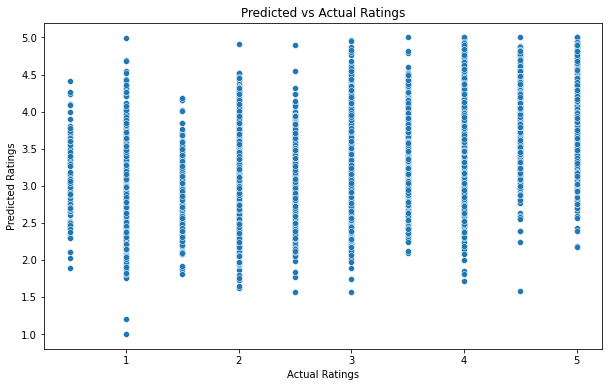

In [790]:

from surprise import Reader, Dataset, SVD, accuracy
from surprise.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a DataFrame 'user_movie' with columns 'userId', 'movieId', and 'rating'
reader = Reader()
# Load your dataset
data = Dataset.load_from_df(user_movie, reader)

# Split the data into train and test sets
trainset, testset = train_test_split(data, test_size=0.40)

# Train the SVD model
model = SVD()
model.fit(trainset)

# Make predictions on the test set
predictions = model.test(testset)

# Calculate MAE and RMSE
mae = accuracy.mae(predictions)
print(f'MAE: {mae}')
rmse = accuracy.rmse(predictions)
print(f'RMSE: {rmse}')

# Visualize predicted vs actual ratings
actual_ratings = [rating for _, _, rating in testset]
predicted_ratings = [pred.est for pred in predictions]

plt.figure(figsize=(10, 6))
sns.scatterplot(x=actual_ratings, y=predicted_ratings)
plt.title('Predicted vs Actual Ratings')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.show()

In [791]:
results = cross_validate(model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8987  0.8989  0.8983  0.8850  0.8898  0.8941  0.0057  
MAE (testset)     0.6913  0.6926  0.6937  0.6832  0.6872  0.6896  0.0039  
Fit time          0.23    0.27    0.25    0.25    0.26    0.25    0.01    
Test time         1.50    0.03    0.03    0.03    0.03    0.32    0.59    


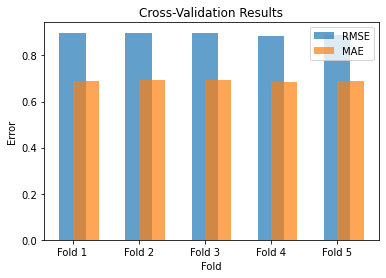

In [792]:
rmse_values = results['test_rmse']
mae_values = results['test_mae']

# Plot the results
labels = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5']
x = range(1, 6)

plt.bar(x, rmse_values, width=0.4, label='RMSE', align='center', alpha=0.7)
plt.bar(x, mae_values, width=0.4, label='MAE', align='edge', alpha=0.7)

plt.xlabel('Fold')
plt.ylabel('Error')
plt.title('Cross-Validation Results')
plt.xticks(x, labels)
plt.legend()
plt.show()

RMSE: 0.8921
RMSE: 0.8933
RMSE: 0.8935
RMSE: 0.8950
RMSE: 0.8955


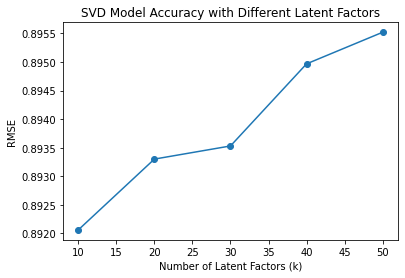

In [793]:


# Load your dataset
data1 = Dataset.load_from_df(user_movie, reader)

# Split the data into train and test sets
trainset, testset = train_test_split(data1, test_size=0.40)

# Define a range of k values to try
k_values = [10, 20, 30, 40, 50]

# Train the SVD model for each k value
rmse_values = []
for k in k_values:
    model = SVD(n_factors=k)
    model.fit(trainset)
    predictions = model.test(testset)
    rmse = accuracy.rmse(predictions)
    rmse_values.append(rmse)

# Plot the results
plt.plot(k_values, rmse_values, marker='o')
plt.xlabel('Number of Latent Factors (k)')
plt.ylabel('RMSE')
plt.title('SVD Model Accuracy with Different Latent Factors')
plt.show()

In [794]:
user_id_to_predict = 10
items_to_predict = [303]  # List of items to predict
for item_id in items_to_predict:
    rating = model.predict(user_id_to_predict, item_id).est
    print(f'Predicted rating for {item_id}: {rating}')

Predicted rating for 303: 3.205195766065108


In [795]:
movie_id_to_name=new_df[["id","original_title"]]
movie_id_to_name

,id,original_title
0,862.0,Toy Story
1,8844.0,Jumanji
2,15602.0,Grumpier Old Men
3,31357.0,Waiting to Exhale
4,11862.0,Father of the Bride Part II
...,...,...
9202,159550.0,The Last Brickmaker in America
9203,392572.0,रुस्तम
9204,402672.0,Mohenjo Daro
9205,315011.0,シン・ゴジラ


In [796]:

def prediction(user_id_to_predict, item_id):
    predictions_for_user = {}
    rating = model.predict(user_id_to_predict, item_id).est
    predictions_for_user[item_id] = rating
    # Output movie ratings with movie names
    #for item_id, rating in predictions_for_user.items():
     #   movie_name = movie_id_to_name[movie_id_to_name['id']==item_id].original_title
      #  print(f'Predicted rating for {movie_name}: {rating}')
    sorted_predictions = sorted(predictions_for_user.items(), key=lambda x: x[1], reverse=True)

    # Display the top 10 recommended movies
    print(f"Recommended Movies for user {user_id_to_predict}:")
    for item_id, rating in sorted_predictions[:10]:
        movie_name = new_df[new_df['id']==item_id].original_title
        print(f'Predicted rating for {movie_name}: {rating}')

In [797]:
prediction(25,307)

Recommended Movies for user 25:
Predicted rating for 4089    Roma città aperta
Name: original_title, dtype: object: 3.983056457638809


In [798]:
new_df

,index,id,original_title,tags,vote_average,vote_count
0,0,862.0,Toy Story,"led by woody, andy' toy live happili in hi roo...",7.7,5415.0
1,1,8844.0,Jumanji,when sibl judi and peter discov an enchant boa...,6.9,2413.0
2,2,15602.0,Grumpier Old Men,a famili wed reignit the ancient feud between ...,6.5,92.0
3,3,31357.0,Waiting to Exhale,"cheat on, mistreat and step on, the women are ...",6.1,34.0
4,4,11862.0,Father of the Bride Part II,just when georg bank ha recov from hi daughter...,5.7,173.0
...,...,...,...,...,...,...
9202,40952,159550.0,The Last Brickmaker in America,a man must cope with the loss of hi wife and t...,7.0,1.0
9203,41172,392572.0,रुस्तम,"rustom pavri, an honour offic of the indian na...",7.3,25.0
9204,41225,402672.0,Mohenjo Daro,"villag lad sarman is drawn to big, bad mohenjo...",6.7,26.0
9205,41391,315011.0,シン・ゴジラ,from the mind behind evangelion come a hit lar...,6.6,152.0


In [799]:
new_df.index

RangeIndex(start=0, stop=9207, step=1)

In [800]:
id_map = pd.read_csv('links_small.csv')[['movieId', 'tmdbId']]
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)
id_map.columns = ['movieId', 'id']
id_map = id_map.merge(smd[['title', 'id']], on='id').set_index('title')

In [801]:
indices_map = id_map.set_index('movieId')

In [802]:
def hybrid(userId, title):
    index=new_df[new_df['original_title']==title].index[0]
    distance=similarity[index]
    movie_list=sorted(list(enumerate(distance)),reverse=True,key=lambda x:x[1])[1:26]
    movie_indices = [i[0] for i in movie_list]
    movies = new_df.iloc[movie_indices][['original_title','vote_count','vote_average','id']]
    

# Create a new column 'est' in movies DataFrame by applying the lambda function in a loop
    movies['est'] = 0  # Initialize the column

    for index, row in movies.iterrows():
        movie_id = row['id']
        est_value = model.predict(userId, indices_map.loc[indices_map['id'] == movie_id]['id'].values[0]).est
        movies.at[index, 'est'] = est_value 
        
    movies = movies.sort_values('est', ascending=False)
    return movies.head(10)

In [803]:
index=new_df[new_df['original_title']=='Avatar'].index[0]
print(new_df.iloc[index][['id']])

id    19995.0
Name: 7482, dtype: object


In [804]:
hybrid(6, 'Spider-Man')

,original_title,vote_count,vote_average,id,est
8850,Shriek If You Know What I Did Last Friday the ...,70.0,4.8,4226.0,3.903028
4187,Eight Legged Freaks,303.0,5.4,8869.0,3.323969
8655,悪の教典,51.0,6.8,120852.0,3.323969
2128,Superman III,500.0,5.3,9531.0,3.323969
6231,Fantastic Four,3040.0,5.5,9738.0,3.323969
8289,倚天屠龍記之魔教教主,14.0,6.8,10852.0,3.323969
2648,Snow Day,51.0,4.8,15489.0,3.323969
7377,The Curiosity of Chance,15.0,5.8,12839.0,3.323969
1496,Small Soldiers,522.0,6.2,11551.0,3.323969
4630,X2,3572.0,6.8,36658.0,3.323969
